# Q2 Weather Recognition

In [2]:
import os
from PIL import Image

import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt

from tqdm import tqdm 

## 1. Data Construction

### (1) DataLoader

In [2]:
data_dir = 'Data_Q2/train_data'

# Transform Define
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# DataLoader
class WeatherDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Class Encoding
        label_str = img_name.split('.')[0] 
        label = 0 
        if 'Sunny' in label_str:
            label = 0
        elif 'Snowy' in label_str:
            label = 1
        elif 'Cloudy' in label_str:
            label = 2
        elif 'Rainy' in label_str:
            label = 3
        elif 'Foggy' in label_str:
            label = 4

        return image, label

dataset = WeatherDataset(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

### (2) Visualization

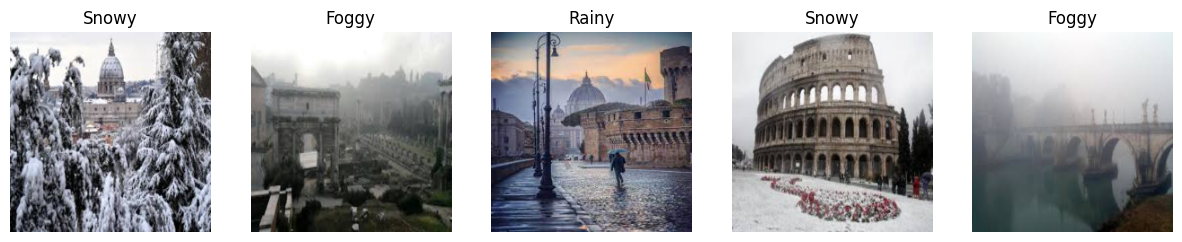

In [4]:
# Obtain data from a batch for visualization
dataset = WeatherDataset(data_dir, transform=transform)
sample_dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)
images, labels = next(iter(sample_dataloader))
images = images.numpy().transpose((0, 2, 3, 1))

# Define category names
class_names = ['Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Foggy']

# Visualization
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()

## 3. Model Training (Pretrained Model Tunning)

In [3]:
# Load pre trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the last layer to adapt to the classification task of five weather categories
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

D:\Anaconda\envs\python3.8_torch2.1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\python3.8_torch2.1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
from torchsummary import summary
summary(model, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
# Defining loss functions and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Hyperparamer
num_epochs = 50 # batch_size = 32

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(dataloader), 0):  # 在dataloader上添加进度条
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(dataloader)}")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 1/50 Loss: 1.5818432867527008


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 2/50 Loss: 1.1719733849167824


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 3/50 Loss: 0.7912936881184578


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.47s/it]


Epoch 4/50 Loss: 0.5324769951403141


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 5/50 Loss: 0.38095011934638023


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.22s/it]


Epoch 6/50 Loss: 0.2713824175298214


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.09s/it]


Epoch 7/50 Loss: 0.22849539667367935


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.42s/it]


Epoch 8/50 Loss: 0.1980300322175026


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.77s/it]


Epoch 9/50 Loss: 0.13212693203240633


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.88s/it]


Epoch 10/50 Loss: 0.10709165222942829


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.04s/it]


Epoch 11/50 Loss: 0.08428610861301422


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.71s/it]


Epoch 12/50 Loss: 0.07987293740734458


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.95s/it]


Epoch 13/50 Loss: 0.06578357145190239


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


Epoch 14/50 Loss: 0.07242512376978993


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.71s/it]


Epoch 15/50 Loss: 0.05181922949850559


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 16/50 Loss: 0.0482139359228313


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 17/50 Loss: 0.043667460558936


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.69s/it]


Epoch 18/50 Loss: 0.03961980203166604


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


Epoch 19/50 Loss: 0.04078582744114101


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.87s/it]


Epoch 20/50 Loss: 0.033461347222328186


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


Epoch 21/50 Loss: 0.029792733723297715


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 22/50 Loss: 0.03490918525494635


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.02s/it]


Epoch 23/50 Loss: 0.026414856896735728


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 24/50 Loss: 0.026955816196277738


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.57s/it]


Epoch 25/50 Loss: 0.021056100842542946


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 26/50 Loss: 0.025254228617995977


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 27/50 Loss: 0.01861602091230452


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 28/50 Loss: 0.01985774701461196


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.68s/it]


Epoch 29/50 Loss: 0.01707497169263661


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 30/50 Loss: 0.01297594711650163


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.70s/it]


Epoch 31/50 Loss: 0.01353093795478344


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.68s/it]


Epoch 32/50 Loss: 0.022003076621331275


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 33/50 Loss: 0.014886625460349023


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.77s/it]


Epoch 34/50 Loss: 0.021353226504288614


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.07s/it]


Epoch 35/50 Loss: 0.012671649106778204


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:28<00:00,  3.53s/it]


Epoch 36/50 Loss: 0.011731548176612705


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.71s/it]


Epoch 37/50 Loss: 0.016986238886602223


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 38/50 Loss: 0.0159974442794919


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 39/50 Loss: 0.012872329680249095


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 40/50 Loss: 0.014022674004081637


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 41/50 Loss: 0.012764598766807467


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.50s/it]


Epoch 42/50 Loss: 0.010513761546462774


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 43/50 Loss: 0.010001979419030249


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.65s/it]


Epoch 44/50 Loss: 0.01689413149142638


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.57s/it]


Epoch 45/50 Loss: 0.011565679975319654


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 46/50 Loss: 0.009617117524612695


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 47/50 Loss: 0.008789917163085192


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 48/50 Loss: 0.0089359600096941


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.68s/it]


Epoch 49/50 Loss: 0.013098844501655549


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.54s/it]

Epoch 50/50 Loss: 0.007046281942166388


## 4. Model Evaluation as Required (On the whole Train set) 

In [8]:
# Model Evaluation On the whole Train set
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(dataloader):  
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on training data: {accuracy}')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]

Accuracy on training data: 1.0
